<a href="https://colab.research.google.com/github/karginb/classifications_with_tensorflow/blob/main/05_transfer_learning_in_tensorflow_fine_tuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 05. Transfer Learning with TensorFlow Part 2: Fine-tuning
In the previous section, we saw how we could leverage feature extraction transfer learning to get far better results on our Food Vision project than building our own models (even with less data).

Now we're going to cover another type of transfer learning: fine-tuning.

In fine-tuning transfer learning the pre-trained model weights from another model are unfrozen and tweaked during to better suit your own data.

For feature extraction transfer learning, you may only train the top 1-3 layers of a pre-trained model with your own data, in fine-tuning transfer learning, you might train 1-3+ layers of a pre-trained model (where the '+' indicates that many or all of the layers could be trained).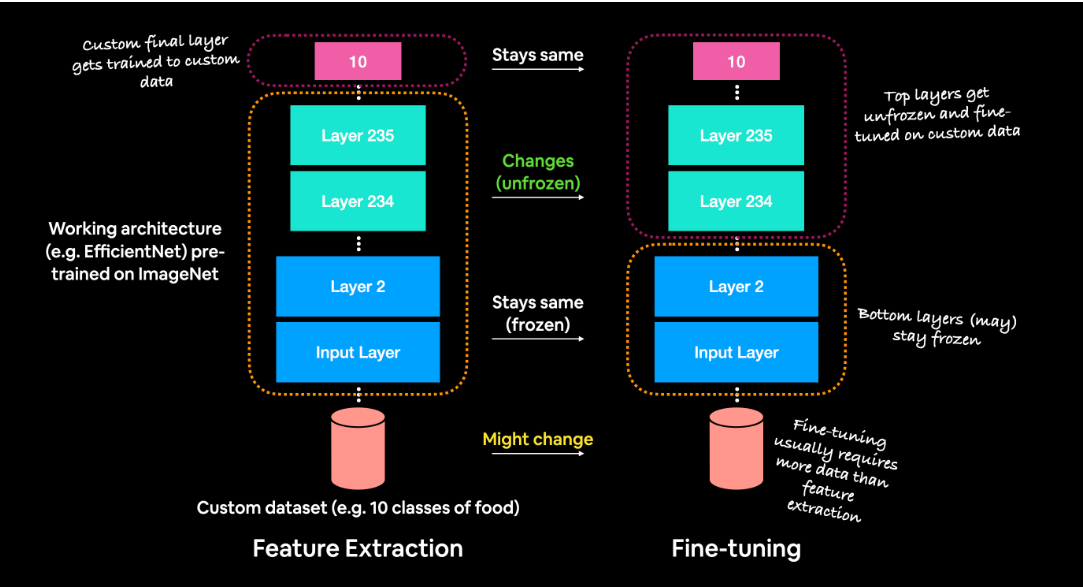

In [1]:
import datetime

print(datetime.datetime.now())

2023-11-05 09:35:51.108170


In [2]:
import tensorflow as tf

print(f"Tensorflow version that we are using: {tf.__version__}")

Tensorflow version that we are using: 2.14.0


In [3]:
!nvidia-smi

Sun Nov  5 09:35:55 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   45C    P8     9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## 10 Food Classes: Working with less data
We saw in the previous notebook that we could get great results with only 10% of the training data using transfer learning with TensorFlow Hub.

In this notebook, we're going to continue to work with smaller subsets of the data, except this time we'll have a look at how we can use the in-built pretrained models within the tf.keras.applications module as well as how to fine-tune them to our own custom dataset.

We'll also practice using a new but similar dataloader function to what we've used before, image_dataset_from_directory() which is part of the tf.keras.utils module.

Finally, we'll also be practicing using the Keras Functional API for building deep learning models. The Functional API is a more flexible way to create models than the tf.keras.Sequential API.

We'll explore each of these in more detail as we go.

Let's start by downloading some data.

In [4]:
import zipfile
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

--2023-11-05 09:36:00--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.20.207, 74.125.135.207, 74.125.142.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.20.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M   277MB/s    in 0.6s    

2023-11-05 09:36:01 (277 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [5]:
zip_ref = zipfile.ZipFile("10_food_classes_10_percent.zip")
zip_ref.extractall()
zip_ref.close()

In [6]:
import os

for dirpath,dirnames,filenames in os.walk("10_food_classes_10_percent"):
  print(f"There are {len(dirnames)} directories and {len(filenames)} images in {dirpath}")

There are 2 directories and 0 images in 10_food_classes_10_percent
There are 10 directories and 0 images in 10_food_classes_10_percent/train
There are 0 directories and 75 images in 10_food_classes_10_percent/train/hamburger
There are 0 directories and 75 images in 10_food_classes_10_percent/train/ramen
There are 0 directories and 75 images in 10_food_classes_10_percent/train/steak
There are 0 directories and 75 images in 10_food_classes_10_percent/train/sushi
There are 0 directories and 75 images in 10_food_classes_10_percent/train/fried_rice
There are 0 directories and 75 images in 10_food_classes_10_percent/train/chicken_wings
There are 0 directories and 75 images in 10_food_classes_10_percent/train/chicken_curry
There are 0 directories and 75 images in 10_food_classes_10_percent/train/ice_cream
There are 0 directories and 75 images in 10_food_classes_10_percent/train/pizza
There are 0 directories and 75 images in 10_food_classes_10_percent/train/grilled_salmon
There are 10 director

In [7]:
train_dir_10_percent = "10_food_classes_10_percent/train/"
test_dir_10_percent = "10_food_classes_10_percent/test/"

Now we've got some image data, we need a way of loading it into a TensorFlow compatible format.

Previously, we've used the ImageDataGenerator class.

However, as of August 2023, this class is deprecated and isn't recommended for future usage (it's too slow).

Because of this, we'll move onto using tf.keras.utils.image_dataset_from_directory().

This method expects image data in the following file format:

Example of file structure

10_food_classes_10_percent <- top level folder
└───train <- training images
│   └───pizza
│   │   │   1008104.jpg
│   │   │   1638227.jpg
│   │   │   ...      
│   └───steak
│       │   1000205.jpg
│       │   1647351.jpg
│       │   ...
│   
└───test <- testing images
│   └───pizza
│   │   │   1001116.jpg
│   │   │   1507019.jpg
│   │   │   ...      
│   └───steak
│       │   100274.jpg
│       │   1653815.jpg
│       │   ...    
One of the main benefits of using tf.keras.prepreprocessing.image_dataset_from_directory() rather than ImageDataGenerator is that it creates a tf.data.Dataset object rather than a generator.

The main advantage of this is the tf.data.Dataset API is much more efficient (faster) than the ImageDataGenerator API which is paramount for larger datasets.

Let's see it in action.

In [8]:
train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir_10_percent,
                                                                 label_mode = "categorical",
                                                                 image_size = (224, 224),
                                                                 batch_size = 32)

test_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(test_dir_10_percent,
                                                                label_mode = "categorical",
                                                                image_size = (224, 224),
                                                                )

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


Wonderful! Looks like our dataloaders have found the correct number of images for each dataset.

For now, the main parameters we're concerned about in the image_dataset_from_directory() funtion are:

* directory - the filepath of the target directory we're loading images in from.
* image_size - the target size of the images we're going to load in (height, width).
* batch_size - the batch size of the images we're going to load in. For example if the batch_size is 32 (the default), batches of 32 images and labels at a time will be passed to the model.
There are more we could play around with if we needed to [in the documentation.

If we check the training data datatype we should see it as a BatchDataset with shapes relating to our data.

In [9]:
train_data_10_percent

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 10), dtype=tf.float32, name=None))>

In the above output:

* (None, 224, 224, 3) refers to the tensor shape of our images where None is the batch size, 224 is the height (and width) and 3 is the color channels (red, green, blue).
* (None, 10) refers to the tensor shape of the labels where None is the batch size and 10 is the number of possible labels (the 10 different food classes).
* Both image tensors and labels are of the datatype tf.float32.

The batch_size is None due to it only being used during model training. You can think of None as a placeholder waiting to be filled with the batch_size parameter from image_dataset_from_directory().

Another benefit of using the tf.data.Dataset API are the assosciated methods which come with it.

For example, if we want to find the name of the classes we were working with, we could use the class_names attribute.

In [10]:
train_data_10_percent.class_names

['chicken_curry',
 'chicken_wings',
 'fried_rice',
 'grilled_salmon',
 'hamburger',
 'ice_cream',
 'pizza',
 'ramen',
 'steak',
 'sushi']

In [11]:
# Or if we wanted to see an example batch of data, we could use the take() method.
for images, labels in train_data_10_percent.take(2):
  print(images, labels)

tf.Tensor(
[[[[1.36056122e+02 5.40561218e+01 0.00000000e+00]
   [1.40000000e+02 5.80000000e+01 0.00000000e+00]
   [1.39642853e+02 5.76428566e+01 4.28571701e-01]
   ...
   [8.59947968e+01 7.46375885e+01 5.84233246e+01]
   [8.80917892e+01 7.51632309e+01 5.59489059e+01]
   [7.88979874e+01 6.68979874e+01 4.33571434e+01]]

  [[1.36357147e+02 5.43571434e+01 0.00000000e+00]
   [1.40066330e+02 5.80663261e+01 6.63265213e-02]
   [1.40484695e+02 5.84846954e+01 4.84694123e-01]
   ...
   [8.66427917e+01 7.52855835e+01 5.91019287e+01]
   [9.15049973e+01 7.85713348e+01 5.93723221e+01]
   [8.15053177e+01 6.95053177e+01 4.75053177e+01]]

  [[1.37566330e+02 5.55663261e+01 0.00000000e+00]
   [1.40928574e+02 5.89285736e+01 9.28571701e-01]
   [1.41214279e+02 5.92142868e+01 8.77550960e-01]
   ...
   [8.58570786e+01 7.44998703e+01 5.87141342e+01]
   [8.94693146e+01 7.80407486e+01 5.82550316e+01]
   [8.83473053e+01 7.71330185e+01 5.51330223e+01]]

  ...

  [[1.13571424e+01 1.43571424e+01 5.35714293e+00]
   [9

## Model 0: Building a transfer learning model using the Keras Functional API
Alright, our data is tensor-ified, let's build a model.

To do so we're going to be using the tf.keras.applications module as it contains a series of already trained (on ImageNet) computer vision models as well as the Keras Functional API to construct our model.

We're going to go through the following steps:

1. Instantiate a pre-trained base model object by choosing a target model such as EfficientNetV2B0 from tf.keras.applications.efficientnet_v2, setting the include_top parameter to False (we do this because we're going to create our own top, which are the output layers for the model).
2. Set the base model's trainable attribute to False to freeze all of the weights in the pre-trained model.
3. Define an input layer for our model, for example, what shape of data should our model expect?
4. [Optional] Normalize the inputs to our model if it requires. Some computer vision models such as ResNetV250 require their inputs to be between 0 & 1.
>🤔 Note: As of writing, the EfficientNet (and EfficientNetV2) models in the tf.keras.applications module do not require images to be normalized (pixel values between 0 and 1) on input, where as many of the other models do. I posted an issue to the TensorFlow GitHub about this and they confirmed this.

5. Pass the inputs to the base model.
6. Pool the outputs of the base model into a shape compatible with the output activation layer (turn base model output tensors into same shape as label tensors). This can be done using tf.keras.layers.GlobalAveragePooling2D() or tf.keras.layers.GlobalMaxPooling2D() though the former is more common in practice.
7. Create an output activation layer using tf.keras.layers.Dense() with the appropriate activation function and number of neurons.
8. Combine the inputs and outputs layer into a model using tf.keras.Model().
9. Compile the model using the appropriate loss function and choose of optimizer.
10. Fit the model for desired number of epochs and with necessary callbacks (in our case, we'll start off with the TensorBoard callback).

In [12]:
import datetime
def create_tensorboard_callback(dir_name, experiment_name):
  log_dir = dir_name + "/" + experiment_name + "/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
  tensorboard_callback = tf.keras.callbacks.TensorBoard(
      log_dir = log_dir
  )

  print(f"Saving Tensorboard log file to: {log_dir}")
  return tensorboard_callback

In [13]:
base_model = tf.keras.applications.efficientnet_v2.EfficientNetV2B0(include_top = False)

base_model.trainable = False

inputs = tf.keras.layers.Input(shape = (224, 224, 3), name = "input_layer")

x = base_model(inputs)

print(f"Shape after base_model: {x.shape}")

x = tf.keras.layers.GlobalAveragePooling2D(name = "global_average_pooling_layer")(x)
print(f"Shape after Global Average Pooling Layer {x.shape}")

outputs = tf.keras.layers.Dense(10, activation = "softmax", name = "output_layer")(x)

model_0 = tf.keras.Model(inputs, outputs)

model_0.compile(loss = "categorical_crossentropy",
                optimizer = tf.keras.optimizers.Adam(),
                metrics = ["accuracy"])

model_0_history = model_0.fit(train_data_10_percent,
                              epochs = 5,
                              steps_per_epoch = len(train_data_10_percent),
                              validation_data = test_data_10_percent,
                              validation_steps = int(0.25 * len(test_data_10_percent)),
                              callbacks = create_tensorboard_callback("transfer_learning",
                                                                      "10_percent_feature_extract"))

24274472/24274472 [==============================] - 0s 0us/step
Shape after base_model: (None, 7, 7, 1280)
Shape after Global Average Pooling Layer (None, 1280)
Saving Tensorboard log file to: transfer_learning/10_percent_feature_extract/20231105-093733
Epoch 1/5
24/24 [==============================] - 26s 234ms/step - loss: 1.8369 - accuracy: 0.4293 - val_loss: 1.2478 - val_accuracy: 0.7303
Epoch 2/5
24/24 [==============================] - 4s 173ms/step - loss: 1.1338 - accuracy: 0.7400 - val_loss: 0.8560 - val_accuracy: 0.8240
Epoch 3/5
24/24 [==============================] - 5s 173ms/step - loss: 0.8357 - accuracy: 0.8133 - val_loss: 0.6949 - val_accuracy: 0.8421
Epoch 4/5
24/24 [==============================] - 6s 203ms/step - loss: 0.6803 - accuracy: 0.8427 - val_loss: 0.5820 - val_accuracy: 0.8832
Epoch 5/5
24/24 [==============================] - 4s 170ms/step - loss: 0.5872 - accuracy: 0.8760 - val_loss: 0.5264 - val_accuracy: 0.8783


Nice! After a minute or so of training our model performs incredibly well on both the training and test sets.

This is incredible.

All thanks to the power of transfer learning!

It's important to note the kind of transfer learning we used here is called feature extraction transfer learning, similar to what we did with the TensorFlow Hub models.

In other words, we passed our custom data to an already pre-trained model (EfficientNetV2B0), asked it "what patterns do you see?" and then put our own output layer on top to make sure the outputs were tailored to our desired number of classes.

We also used the Keras Functional API to build our model rather than the Sequential API. For now, the benefits of this main not seem clear but when you start to build more sophisticated models, you'll probably want to use the Functional API. So it's important to have exposure to this way of building models.

> 📖 Resource: To see the benefits and use cases of the Functional API versus the Sequential API, check out the TensorFlow Functional API documentation.

In [14]:
for layer_number, layer in enumerate(base_model.layers):
  print(layer_number, layer.name)

0 input_1
1 rescaling
2 normalization
3 stem_conv
4 stem_bn
5 stem_activation
6 block1a_project_conv
7 block1a_project_bn
8 block1a_project_activation
9 block2a_expand_conv
10 block2a_expand_bn
11 block2a_expand_activation
12 block2a_project_conv
13 block2a_project_bn
14 block2b_expand_conv
15 block2b_expand_bn
16 block2b_expand_activation
17 block2b_project_conv
18 block2b_project_bn
19 block2b_drop
20 block2b_add
21 block3a_expand_conv
22 block3a_expand_bn
23 block3a_expand_activation
24 block3a_project_conv
25 block3a_project_bn
26 block3b_expand_conv
27 block3b_expand_bn
28 block3b_expand_activation
29 block3b_project_conv
30 block3b_project_bn
31 block3b_drop
32 block3b_add
33 block4a_expand_conv
34 block4a_expand_bn
35 block4a_expand_activation
36 block4a_dwconv2
37 block4a_bn
38 block4a_activation
39 block4a_se_squeeze
40 block4a_se_reshape
41 block4a_se_reduce
42 block4a_se_expand
43 block4a_se_excite
44 block4a_project_conv
45 block4a_project_bn
46 block4b_expand_conv
47 block

In [15]:
base_model.summary()

Model: "efficientnetv2-b0"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, None, None, 3)]      0         []                            
                                                                                                  
 rescaling (Rescaling)       (None, None, None, 3)        0         ['input_1[0][0]']             
                                                                                                  
 normalization (Normalizati  (None, None, None, 3)        0         ['rescaling[0][0]']           
 on)                                                                                              
                                                                                                  
 stem_conv (Conv2D)          (None, None, None, 32)       864       ['normalizatio

In [16]:
model_0.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetv2-b0 (Functio  (None, None, None, 1280   5919312   
 nal)                        )                                   
                                                                 
 global_average_pooling_lay  (None, 1280)              0         
 er (GlobalAveragePooling2D                                      
 )                                                               
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 5932122 (22.63 MB)
Trainable params: 12810 (50.04 KB)
Non-trainable params: 5919312 (22.58 MB)
__________________

In [17]:
import matplotlib.pyplot as plt
def plot_loss_curves(history):
  accuracy = history.history["accuracy"]
  loss = history.history["loss"]

  val_accuracy = history.history["val_accuracy"]
  val_loss = history.history["val_loss"]

  epoch = range(len(history.history["loss"]))

  plt.plot(epoch, accuracy, label = "Trainig Accuracy")
  plt.plot(epoch, val_accuracy, label = "Testing Accuracy")
  plt.title("Accuracy")
  plt.xlabel("Epochs")
  plt.legend()

  plt.figure()

  plt.plot(epoch, loss, label = "Trainig Loss")
  plt.plot(epoch, val_loss, label = "Testing Loss")
  plt.title("Loss")
  plt.xlabel("Epochs")
  plt.legend()

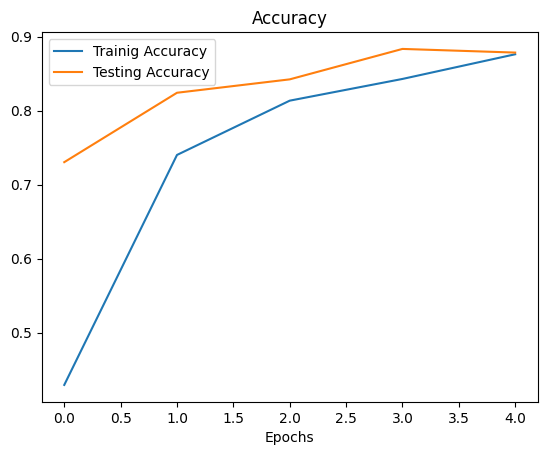

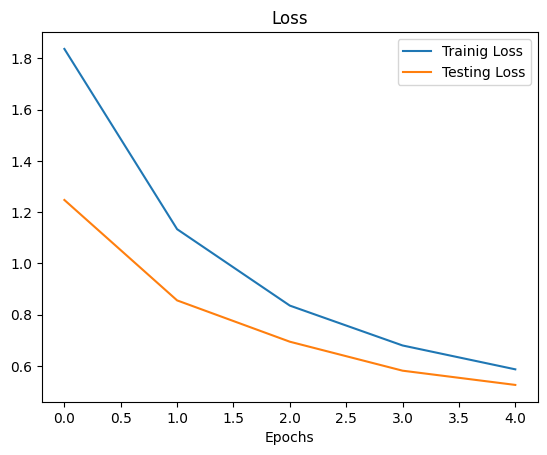

In [18]:
plot_loss_curves(model_0.history)

## Getting a feature vector from a trained model

The tf.keras.layers.GlobalAveragePooling2D() layer transforms a 4D tensor into a 2D tensor by averaging the values across the inner-axes.

The previous sentence is a bit of a mouthful, so let's see an exam

In [ ]:
input_shape = (1, 4, 4, 3)

tf.random.set_seed(42)
input_tensor = tf.random.normal(input_shape)
print(f"Random input tensor:\n {input_tensor}")

global_average_pooling_tensor = tf.keras.layers.GlobalAveragePooling2D()(input_tensor)
print(f"Random input tenso's shape:\n {input_tensor.shape}")
print(f"Shape of global averaged pooling tensor's shape:\n {global_average_pooling_tensor.shape}")

Random input tensor:
 [[[[ 0.3274685  -0.8426258   0.3194337 ]
   [-1.4075519  -2.3880599  -1.0392479 ]
   [-0.5573232   0.539707    1.6994323 ]
   [ 0.28893656 -1.5066116  -0.2645474 ]]

  [[-0.59722406 -1.9171132  -0.62044144]
   [ 0.8504023  -0.40604794 -3.0258412 ]
   [ 0.9058464   0.29855987 -0.22561555]
   [-0.7616443  -1.8917141  -0.93847126]]

  [[ 0.77852213 -0.47338894  0.97772694]
   [ 0.24694404  0.20573746 -0.52562326]
   [ 0.32410017  0.02545409 -0.10638496]
   [-0.63694745  1.1603122   0.2507359 ]]

  [[-0.41728503  0.4012578  -1.4145443 ]
   [-0.5931857  -1.6617213   0.33567193]
   [ 0.10815628  0.23479679 -0.56668764]
   [-0.35819843  0.88698614  0.52744764]]]]
Random input tenso's shape:
 (1, 4, 4, 3)
Shape of global averaged pooling tensor's shape:
 (1, 3)


In [ ]:
global_max_pool_tensor = tf.keras.layers.GlobalMaxPool2D()(input_tensor)

global_max_pool_tensor.shape

TensorShape([1, 3])

You can see the tf.keras.layers.GlobalAveragePooling2D() layer condensed the input tensor from shape (1, 4, 4, 3) to (1, 3). It did so by averaging the input_tensor across the middle two axes.

We can replicate this operation using the tf.reduce_mean() operation and specifying the appropriate axes.



In [ ]:
tf.reduce_mean(input_tensor, axis = [1, 2])

<tf.Tensor: shape=(1, 3), dtype=float32, numpy=array([[-0.09368646, -0.45840448, -0.2885598 ]], dtype=float32)>

Doing this not only makes the output of the base model compatible with the input shape requirement of our output layer (tf.keras.layers.Dense()), it also condenses the information found by the base model into a lower dimension feature vector.

>🔑 Note: One of the reasons feature extraction transfer learning is named how it is is because what often happens is a pretrained model outputs a feature vector (a long tensor of numbers, in our case, this is the output of the tf.keras.layers.GlobalAveragePooling2D() layer) which can then be used to extract patterns out of.

## Running a series of transfer learning experiments
We've seen the incredible results of transfer learning on 10% of the training data, what about 1% of the training data?

What kind of results do you think we can get using 100x less data than the original CNN models we built ourselves?

Why don't we answer that question while running the following modelling experiments:

1. Model 1: Use feature extraction transfer learning on 1% of the training data with data augmentation.
2. Model 2: Use feature extraction transfer learning on 10% of the training data with data augmentation and save the results to a checkpoint.
3. Model 3: Fine-tune the Model 2 checkpoint on 10% of the training data with data augmentation.
4. Model 4: Fine-tune the Model 2 checkpoint on 100% of the training data with data augmentation.
While all of the experiments will be run on different versions of the training data, they will all be evaluated on the same test dataset, this ensures the results of each experiment are as comparable as possible.

All experiments will be done using the EfficientNetV2B0 model within the tf.keras.applications.efficientnet_v2 module.

To make sure we're keeping track of our experiments, we'll use our create_tensorboard_callback() function to log all of the model training logs.

We'll construct each model using the Keras Functional API and instead of implementing data augmentation in the ImageDataGenerator class as we have previously, we're going to build it right into the model using the tf.keras.layers module.

Let's begin by downloading the data for experiment 1, using feature extraction transfer learning on 1% of the training data with data augmentation.

In [19]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip

zip_ref_1_percent = zipfile.ZipFile("10_food_classes_1_percent.zip")
zip_ref_1_percent.extractall()
zip_ref_1_percent.close()

--2023-11-05 09:40:04--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.202.207, 173.194.203.207, 74.125.20.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.202.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 133612354 (127M) [application/zip]
Saving to: ‘10_food_classes_1_percent.zip’

10_food_classes_1_p 100%[===================>] 127.42M   141MB/s    in 0.9s    

2023-11-05 09:40:05 (141 MB/s) - ‘10_food_classes_1_percent.zip’ saved [133612354/133612354]



In [20]:
for dirpath, dirname, filename in os.walk("10_food_classes_1_percent"):
  print(f"There are {len(dirnames)} directories and {len(filenames)} images in {dirpath}")

There are 0 directories and 250 images in 10_food_classes_1_percent
There are 0 directories and 250 images in 10_food_classes_1_percent/train
There are 0 directories and 250 images in 10_food_classes_1_percent/train/hamburger
There are 0 directories and 250 images in 10_food_classes_1_percent/train/ramen
There are 0 directories and 250 images in 10_food_classes_1_percent/train/steak
There are 0 directories and 250 images in 10_food_classes_1_percent/train/sushi
There are 0 directories and 250 images in 10_food_classes_1_percent/train/fried_rice
There are 0 directories and 250 images in 10_food_classes_1_percent/train/chicken_wings
There are 0 directories and 250 images in 10_food_classes_1_percent/train/chicken_curry
There are 0 directories and 250 images in 10_food_classes_1_percent/train/ice_cream
There are 0 directories and 250 images in 10_food_classes_1_percent/train/pizza
There are 0 directories and 250 images in 10_food_classes_1_percent/train/grilled_salmon
There are 0 director

In [21]:
train_dir = "10_food_classes_1_percent/train/"
test_dir = "10_food_classes_1_percent/test/"

In [22]:
import tensorflow as tf
train_data_1_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                                           label_mode = "categorical",
                                                                           image_size = (224, 224),
                                                                           batch_size = 32)

test_data_1_percent = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                          label_mode = "categorical",
                                                                          image_size = (224, 224),
                                                                          batch_size = 32)

Found 70 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


Adding data augmentation right into the model
Previously we've used the different parameters of the ImageDataGenerator class to augment our training images, this time we're going to build data augmentation right into the model.

How?

Using the tf.keras.layers module and creating a dedicated data augmentation layer.

This a relatively new feature added to TensorFlow 2.10+ but it's very powerful. Adding a data augmentation layer to the model has the following benefits:

* Preprocessing of the images (augmenting them) happens on the GPU rather than on the CPU (much faster).
  * Images are best preprocessed on the GPU where as text and structured data are more suited to be preprocessed on the CPU.
* Image data augmentation only happens during training so we can still export our whole model and use it elsewhere. And if someone else wanted to train the same model as us, including the same kind of data augment
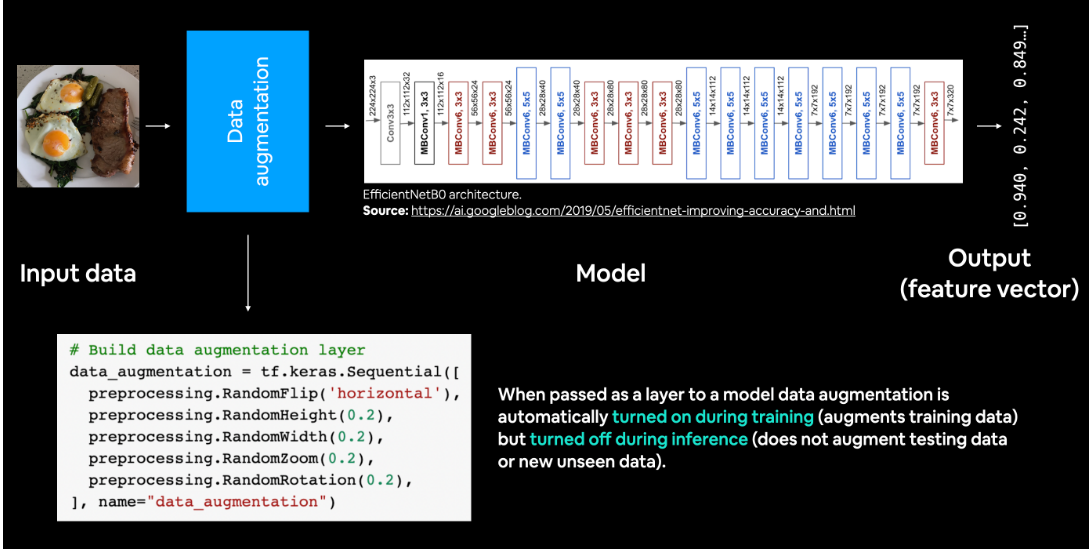



The data augmentation transformations we're going to use are:

* tf.keras.layers.RandomFlip - flips image on horizontal or vertical axis.
* tf.keras.layers.RandomRotation - randomly rotates image by a specified amount.
* tf.keras.layers.RandomZoom - randomly zooms into an image by specified amount.
* tf.keras.layers.RandomHeight - randomly shifts image height by a specified amount.
* tf.keras.layers.RandomWidth - randomly shifts image width by a specified amount.
* tf.keras.layers.Rescaling - normalizes the image pixel values to be between 0 and 1, this is worth mentioning because it is required for some image models but since we're using tf.keras.applications.efficientnet_v2.EfficientNetV2B0, it's not required (the model pretrained model implements rescaling itself).

In [23]:
# from tensorflow.keras.layers.experimental import preprocessing

data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.RandomZoom(0.2),
    tf.keras.layers.RandomHeight(0.2),
    tf.keras.layers.RandomWidth(0.2),
    #tf.keras.layers.Rescaling(), # keep for ResNet50V2, remove for EfficientNetV2B0
], name = "data_augmentation")

# # UPDATE: Previous versions of TensorFlow (e.g. 2.4 and below used the tensorflow.keras.layers.experimental.processing API)
# # Create a data augmentation stage with horizontal flipping, rotations, zooms
# data_augmentation = keras.Sequential([
#   preprocessing.RandomFlip("horizontal"),
#   preprocessing.RandomRotation(0.2),
#   preprocessing.RandomZoom(0.2),
#   preprocessing.RandomHeight(0.2),
#   preprocessing.RandomWidth(0.2),
#   # preprocessing.Rescaling(1./255) # keep for ResNet50V2, remove for EfficientNetV2B0
# ], name ="data_augmentation")

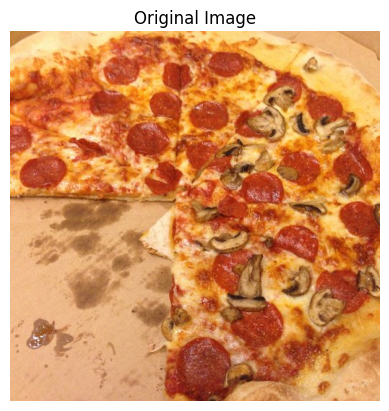

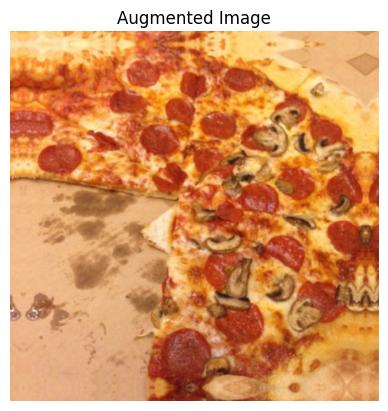

In [24]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import random

target_class = random.choice(train_data_1_percent.class_names)
target_dir = "10_food_classes_1_percent/train/" + target_class
random_image = random.choice(os.listdir(target_dir))
random_image_path = target_dir + "/" + random_image
img = mpimg.imread(random_image_path)
plt.imshow(img)
plt.title("Original Image")
plt.axis("off")

plt.figure()

augmented_img = data_augmentation(tf.expand_dims(img, axis = 0))
plt.imshow(tf.squeeze(augmented_img)/255.)
plt.title("Augmented Image")
plt.axis("off")
plt.show()

Run the cell above a few times and you can see the different random augmentations on different classes of images. Because we're going to add the data augmentation model as a layer in our upcoming transfer learning model, it'll apply these kind of random augmentations to each of the training images which passes through it.

Doing this will make our training dataset a little more varied. You can think of it as if you were taking a photo of food in real-life, not all of the images are going to be perfect, some of them are going to be orientated in strange ways. These are the kind of images we want our model to be able to handle.

Speaking of model, let's build one with the Functional API. We'll run through all of the same steps as before except for one difference, we'll add our data augmentation Sequential model as a layer immediately after the input layer.

## Model 1: Feature extraction transfer learning on 1% of the data with data augmentation

In [25]:
from keras.src.engine.sequential import training
base_model = tf.keras.applications.efficientnet_v2.EfficientNetV2B0(include_top=False)

base_model.trainable = False

inputs = tf.keras.layers.Input(shape = (224, 224, 3), name = "inputs_layer")

x = data_augmentation(inputs)

x = base_model(x, training = False)

x = tf.keras.layers.GlobalAveragePooling2D(name = "global_average_pooling_layer")(x)

outputs = tf.keras.layers.Dense(10, activation = "softmax", name = "outputs_layer")(x)


model_1 = tf.keras.Model(inputs, outputs)

model_1.compile(loss = "categorical_crossentropy",
                optimizer = tf.keras.optimizers.Adam(),
                metrics = "accuracy")


model_1_history = model_1.fit(train_data_1_percent,
                              epochs = 5,
                              steps_per_epoch = len(train_data_1_percent),
                              validation_data = test_data_1_percent,
                              validation_steps = int(0.25 * len(test_data_1_percent)),
                              callbacks = create_tensorboard_callback("transfer_learning",
                                                                      "1_percent_data_augmented"))


Saving Tensorboard log file to: transfer_learning/1_percent_data_augmented/20231105-094106
Epoch 1/5
3/3 [==============================] - 13s 2s/step - loss: 2.3898 - accuracy: 0.1000 - val_loss: 2.2533 - val_accuracy: 0.1661
Epoch 2/5
3/3 [==============================] - 7s 3s/step - loss: 2.2016 - accuracy: 0.1571 - val_loss: 2.1431 - val_accuracy: 0.2385
Epoch 3/5
3/3 [==============================] - 4s 1s/step - loss: 1.9742 - accuracy: 0.4000 - val_loss: 2.0471 - val_accuracy: 0.3421
Epoch 4/5
3/3 [==============================] - 5s 2s/step - loss: 1.8422 - accuracy: 0.5000 - val_loss: 1.9503 - val_accuracy: 0.4145
Epoch 5/5
3/3 [==============================] - 4s 1s/step - loss: 1.6734 - accuracy: 0.6143 - val_loss: 1.8464 - val_accuracy: 0.4720


In [26]:
model_1.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputs_layer (InputLayer)   [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequent  (None, None, None, 3)     0         
 ial)                                                            
                                                                 
 efficientnetv2-b0 (Functio  (None, None, None, 1280   5919312   
 nal)                        )                                   
                                                                 
 global_average_pooling_lay  (None, 1280)              0         
 er (GlobalAveragePooling2D                                      
 )                                                               
                                                                 
 outputs_layer (Dense)       (None, 10)                1281

The important thing to remember is data augmentation only runs during training. So if we were to evaluate or use our model for inference (predicting the class of an image) the data augmentation layers will be automatically turned off.

To see this in action, let's evaluate our model on the test data.

In [29]:
results_model_1 = model_1.evaluate(test_data_1_percent)

results_model_1

79/79 [==============================] - 8s 82ms/step - loss: 1.8650 - accuracy: 0.4392


[1.8650400638580322, 0.4392000138759613]

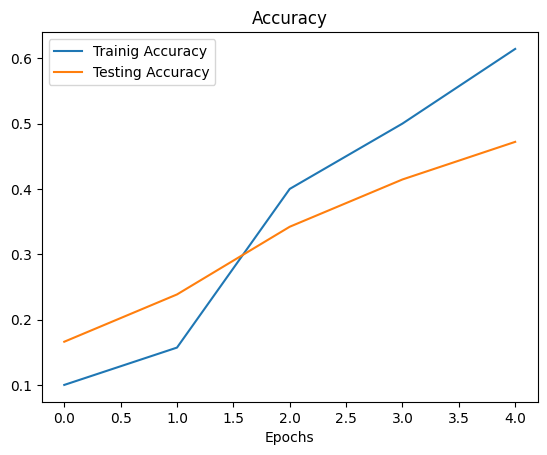

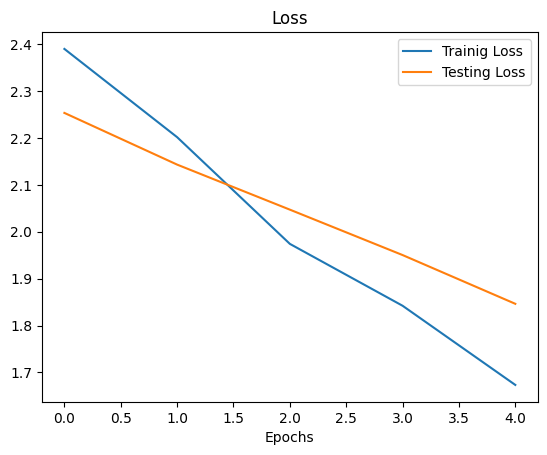

In [30]:
plot_loss_curves(model_1_history)

## Model 2: Feature extraction transfer learning with 10% of data and data augmentation
Alright, we've tested 1% of the training data with data augmentation, how about we try 10% of the data with data augmentation?

But wait...

>🤔 Question: How do you know what experiments to run?

Great question.

The truth here is you often won't. Machine learning is still a very experimental practice. It's only after trying a fair few things that you'll start to develop an intuition of what to try.

My advice is to follow your curiosity as tenaciously as possible. If you feel like you want to try something, write the code for it and run it. See how it goes. The worst thing that'll happen is you'll figure out what doesn't work, the most valuable kind of knowledge.

From a practical standpoint, as we've talked about before, you'll want to reduce the amount of time between your initial experiments as much as possible. In other words, run a plethora of smaller experiments, using less data and less training iterations before you find something promising and then scale it up.

In the theme of scale, let's scale our 1% training data augmentation experiment up to 10% training data augmentation. That sentence doesn't really make sense but you get what I mean.

We're going to run through the exact same steps as the previous model, the only difference being using 10% of the training data instead of 1%.



In [31]:
train_dir_10_percent = "10_food_classes_10_percent/train/"
test_dir_10_percent = "10_food_classes_10_percent/test/"

In [32]:
train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir_10_percent,
                                                                 label_mode = "categorical",
                                                                 image_size = (224, 224),
                                                               )

test_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(test_dir_10_percent,
                                                                 label_mode = "categorical",
                                                                 image_size = (224, 224),
                                                                 )

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [33]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.RandomZoom(0.2),
    tf.keras.layers.RandomHeight(0.2),
    tf.keras.layers.RandomWidth(0.2)
], name = "data_augmentation")

In [37]:
base_model = tf.keras.applications.efficientnet_v2.EfficientNetV2B0(include_top=False)

base_model.trainable = False

inputs = tf.keras.layers.Input(shape= (224, 224, 3), name = "input_layer")

x = data_augmentation(inputs)

x = base_model(x, training = False)

x = tf.keras.layers.GlobalAveragePooling2D(name = "global_average_pooling_layer")(x)

outputs = tf.keras.layers.Dense(10, activation = "softmax", name = "output_layer")(x)

model_2 = tf.keras.Model(inputs, outputs)

model_2.compile(loss = "categorical_crossentropy",
                optimizer = tf.keras.optimizers.Adam(learning_rate=0.001),
                metrics = ["accuracy"])

Saving Tensorboard log file to: transfer_learning/10_percent_augmented/20231105-094545
Epoch 1/5
24/24 [==============================] - 25s 660ms/step - loss: 2.0507 - accuracy: 0.3187 - val_loss: 1.4681 - val_accuracy: 0.7007
Epoch 2/5
24/24 [==============================] - 15s 599ms/step - loss: 1.4321 - accuracy: 0.6253 - val_loss: 1.0204 - val_accuracy: 0.7895
Epoch 3/5
24/24 [==============================] - 14s 556ms/step - loss: 1.1162 - accuracy: 0.7320 - val_loss: 0.8353 - val_accuracy: 0.8076
Epoch 4/5
24/24 [==============================] - 14s 555ms/step - loss: 0.9499 - accuracy: 0.7507 - val_loss: 0.7027 - val_accuracy: 0.8438
Epoch 5/5
24/24 [==============================] - 14s 552ms/step - loss: 0.8515 - accuracy: 0.7853 - val_loss: 0.6371 - val_accuracy: 0.8339


## Creating a ModelCheckpoint callback
Our model is compiled and ready to be fit, so why haven't we fit it yet?

Well, for this experiment we're going to introduce a new callback, the ModelCheckpoint callback.

The ModelCheckpoint callback gives you the ability to save your model, as a whole in the SavedModel format or the weights (patterns) only to a specified directory as it trains.

This is helpful if you think your model is going to be training for a long time and you want to make backups of it as it trains. It also means if you think your model could benefit from being trained for longer, you can reload it from a specific checkpoint and continue training from there.

For example, say you fit a feature extraction transfer learning model for 5 epochs and you check the training curves and see it was still improving and you want to see if fine-tuning for another 5 epochs could help, you can load the checkpoint, unfreeze some (or all) of the base model layers and then continue training.

In fact, that's exactly what we're going to do.

But first, let's create a ModelCheckpoint callback. To do so, we have to specifcy a directory we'd like to save to.

In [43]:
checkpoint_path = "ten_percent_model_checkpoints_weights/checkpoint.ckpt"

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath = checkpoint_path,
                                                     save_weights_only = True,
                                                     save_best_only = True,
                                                     save_freq = "epoch",
                                                     verbose = 1)


In [44]:
model_2_history = model_2.fit(train_data_10_percent,
                              epochs = 5,
                              steps_per_epoch = len(train_data_10_percent),
                              validation_data = test_data_10_percent,
                              validation_steps = int(0.25 * len(test_data_10_percent)),
                              callbacks = [create_tensorboard_callback("transfer_learning",
                                                                      "10_percent_augmented"),checkpoint_callback])

Saving Tensorboard log file to: transfer_learning/10_percent_augmented/20231105-095048
Epoch 1/5
24/24 [==============================] - ETA: 0s - loss: 1.0972 - accuracy: 0.7480
Epoch 1: val_loss improved from inf to 0.86410, saving model to ten_percent_model_checkpoints_weights/checkpoint.ckpt
24/24 [==============================] - 12s 480ms/step - loss: 1.0972 - accuracy: 0.7480 - val_loss: 0.8641 - val_accuracy: 0.7845
Epoch 2/5
24/24 [==============================] - ETA: 0s - loss: 0.9423 - accuracy: 0.7627
Epoch 2: val_loss improved from 0.86410 to 0.72959, saving model to ten_percent_model_checkpoints_weights/checkpoint.ckpt
24/24 [==============================] - 13s 538ms/step - loss: 0.9423 - accuracy: 0.7627 - val_loss: 0.7296 - val_accuracy: 0.8026
Epoch 3/5
24/24 [==============================] - ETA: 0s - loss: 0.8481 - accuracy: 0.7747
Epoch 3: val_loss improved from 0.72959 to 0.66163, saving model to ten_percent_model_checkpoints_weights/checkpoint.ckpt
24/24 [=

In [45]:
results_model_2 = model_2.evaluate(test_data_10_percent)

results_model_2

79/79 [==============================] - 5s 63ms/step - loss: 0.5774 - accuracy: 0.8400


[0.5773836970329285, 0.8399999737739563]

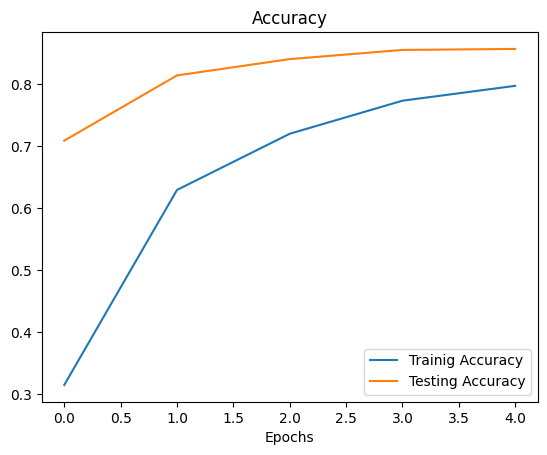

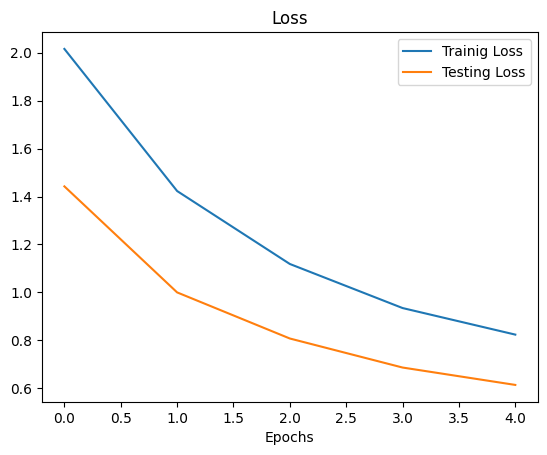

In [ ]:
plot_loss_curves(model_2_history)

In [46]:
model_2.load_weights(checkpoint_path)

loaded_weights_model_results = model_2.evaluate(test_data_10_percent)

loaded_weights_model_results

79/79 [==============================] - 7s 84ms/step - loss: 0.5774 - accuracy: 0.8400


[0.5773836970329285, 0.8399999737739563]

In [47]:
# If the results from our native model and the loaded weights are the same, this should output True
results_model_2 == loaded_weights_model_results

True

In [48]:
import numpy as np

np.isclose(np.array(results_model_2), np.array(loaded_weights_model_results))

array([ True,  True])

In [49]:
np.array(results_model_2) - np.array(loaded_weights_model_results)

array([0., 0.])

# Model 3: Fine-tuning an existing model on 10% of the data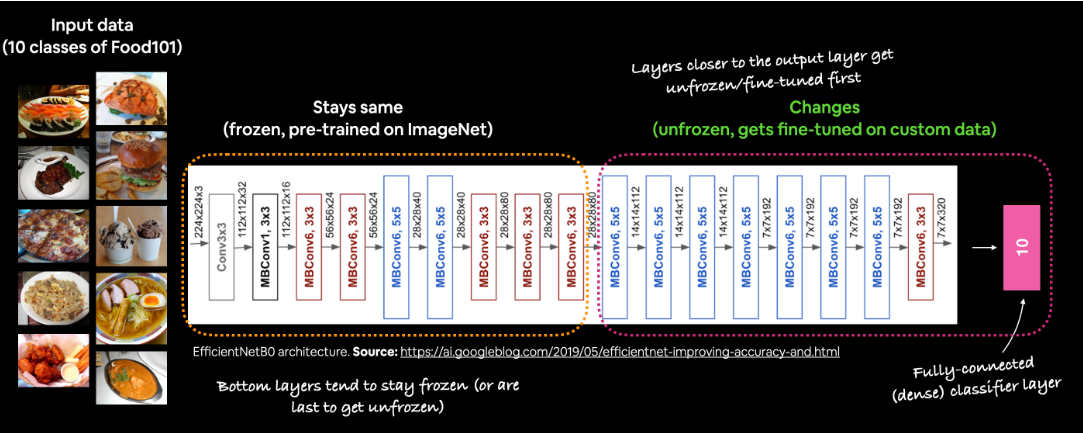

o far our saved model has been trained using feature extraction transfer learning for 5 epochs on 10% of the training data and data augmentation.

This means all of the layers in the base model (EfficientNetV2B0) were frozen during training.

For our next experiment we're going to switch to fine-tuning transfer learning. This means we'll be using the same base model except we'll be unfreezing some of its layers (ones closest to the top) and running the model for a few more epochs.

The idea with fine-tuning is to start customizing the pre-trained model more to our own data.

Beautiful. This is exactly what we're after.

Now to fine-tune the base model to our own data, we're going to unfreeze the top 10 layers and continue training our model for another 5 epochs.

This means all of the base model's layers except for the last 10 will remain frozen and untrainable. And the weights in the remaining unfrozen layers will be updated during training.

Ideally, we should see the model's performance improve.

>🤔 Question: How many layers should you unfreeze when training?

There's no set rule for this. You could unfreeze every layer in the pretrained model or you could try unfreezing one layer at a time. Best to experiment with different amounts of unfreezing and fine-tuning to see what happens. Generally, the less data you have, the less layers you want to unfreeze and the more gradually you want to fine-tune.

>📖 Resource: The ULMFiT (Universal Language Model Fine-tuning for Text Classification) paper has a great series of experiments on fine-tuning models.

To begin fine-tuning, we'll unfreeze the entire model_2_base_model by setting its trainable attribute to True.

Then we'll refreeze every layer in model_2_base_model except for the last 10 by looping through them and setting their trainable attribute to False.

In [56]:
base_model = tf.keras.applications.efficientnet_v2.EfficientNetV2B0(include_top = False)
base_model.trainable = False

inputs = tf.keras.layers.Input(shape = (224, 224, 3), name = "input_layer")
x = data_augmentation(inputs)
x = base_model(x, training = False)
x = tf.keras.layers.GlobalAveragePooling2D(name = "global_average_pooling_layer")(x)
outputs = tf.keras.layers.Dense(10, activation = "softmax", name = "output_layer")(x)
model_3 = tf.keras.Model(inputs, outputs)

In [57]:
model_3_base_model = model_3.layers[2]

In [63]:
model_3_base_model.trainable = True

for layer in model_3_base_model.layers[:-10]:
  layer.trainable = False

model_3_base_model.compile(loss = "categorical_crossentropy",
                optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0001),
                metrics = ["accuracy"])

In [64]:
for layer_number, layer in enumerate(model_3_base_model.layers):
  print(layer_number, layer.name, layer.trainable)

0 input_6 False
1 rescaling_5 False
2 normalization_5 False
3 stem_conv False
4 stem_bn False
5 stem_activation False
6 block1a_project_conv False
7 block1a_project_bn False
8 block1a_project_activation False
9 block2a_expand_conv False
10 block2a_expand_bn False
11 block2a_expand_activation False
12 block2a_project_conv False
13 block2a_project_bn False
14 block2b_expand_conv False
15 block2b_expand_bn False
16 block2b_expand_activation False
17 block2b_project_conv False
18 block2b_project_bn False
19 block2b_drop False
20 block2b_add False
21 block3a_expand_conv False
22 block3a_expand_bn False
23 block3a_expand_activation False
24 block3a_project_conv False
25 block3a_project_bn False
26 block3b_expand_conv False
27 block3b_expand_bn False
28 block3b_expand_activation False
29 block3b_project_conv False
30 block3b_project_bn False
31 block3b_drop False
32 block3b_add False
33 block4a_expand_conv False
34 block4a_expand_bn False
35 block4a_expand_activation False
36 block4a_dwconv2 

Nice! It seems all layers except for the last 10 are frozen and untrainable. This means only the last 10 layers of the base model along with the output layer will have their weights updated during training.

>🤔 Question: Why did we recompile the model?

Every time you make a change to your models, you need to recompile them.

In our case, we're using the exact same loss, optimizer and metrics as before, except this time the learning rate for our optimizer will be 10x smaller than before (0.0001 instead of Adam's default of 0.001).

We do this so the model doesn't try to overwrite the existing weights in the pretrained model too fast. In other words, we want learning to be more gradual.

In [65]:
print(len(model_3_base_model.trainable_variables))

10


In [68]:
print(len(model_3.trainable_variables))

12


In [60]:
initial_epoch = 5
fine_tune_epochs = initial_epoch + 5

In [67]:
model_3_history = model_3.fit(train_data_10_percent,
                epochs = fine_tune_epochs,
                steps_per_epoch = len(train_data_10_percent),
                validation_data = test_data_10_percent,
                initial_epoch = model_2_history.epoch[-1],
                validation_steps = int(0.25 * len(test_data_10_percent)),
                callbacks = [create_tensorboard_callback("transfer_learning",
                                                         "10_percent_fine_tuning")])

Saving Tensorboard log file to: transfer_learning/10_percent_fine_tuning/20231105-095615
Epoch 5/10
24/24 [==============================] - 24s 532ms/step - loss: 2.2203 - accuracy: 0.2200 - val_loss: 1.9024 - val_accuracy: 0.5033
Epoch 6/10
24/24 [==============================] - 10s 389ms/step - loss: 1.8424 - accuracy: 0.4813 - val_loss: 1.4722 - val_accuracy: 0.6365
Epoch 7/10
24/24 [==============================] - 11s 453ms/step - loss: 1.4199 - accuracy: 0.6387 - val_loss: 0.9952 - val_accuracy: 0.7155
Epoch 8/10
24/24 [==============================] - 9s 353ms/step - loss: 1.0965 - accuracy: 0.6667 - val_loss: 0.7688 - val_accuracy: 0.7599
Epoch 9/10
24/24 [==============================] - 11s 434ms/step - loss: 0.8664 - accuracy: 0.7413 - val_loss: 0.6352 - val_accuracy: 0.8043
Epoch 10/10
24/24 [==============================] - 9s 352ms/step - loss: 0.7841 - accuracy: 0.7547 - val_loss: 0.5795 - val_accuracy: 0.8158


In [69]:
results_model_3 = model_3.evaluate(test_data_10_percent)


79/79 [==============================] - 6s 76ms/step - loss: 0.6177 - accuracy: 0.7896


In [70]:
import matplotlib.pyplot as plt
def compare_history(original_history, new_history, initial_epoch):
  acc = original_history.history["accuracy"]
  loss = original_history.history["loss"]

  print(len(acc))

  val_acc = original_history.history["val_accuracy"]
  val_loss = original_history.history["val_loss"]

  total_acc = acc + new_history.history["accuracy"]
  total_loss = loss + new_history.history["loss"]

  total_val_acc = val_acc + new_history.history["val_accuracy"]
  total_val_loss = val_loss + new_history.history["val_loss"]

  print(len(total_acc))
  print(total_acc)

  plt.figure(figsize = (8, 8))
  plt.subplot(2, 1, 1)
  plt.plot(total_acc, label = "Training Accuracy")
  plt.plot(total_val_acc, label = "Testing Accuracy")
  plt.plot([initial_epoch-1, initial_epoch-1], plt.ylim(), label = "Start Fine Tuning")
  plt.legend(loc = "upper right")
  plt.title("Trainig and Testing Accuracy")

  plt.subplot(2, 1, 2)
  plt.plot(total_loss, label = "Training Loss")
  plt.plot(total_val_loss, label = "Testing Loss")
  plt.plot([initial_epoch-1, initial_epoch-1], plt.ylim(), label = "Start Fine Tuning")
  plt.legend(loc = "upper right")
  plt.title("Training and Testing Loss")
  plt.xlabel("Epochs")
  plt.show()

5
11
[0.7480000257492065, 0.762666642665863, 0.7746666669845581, 0.8066666722297668, 0.8226666450500488, 0.2199999988079071, 0.48133334517478943, 0.6386666893959045, 0.6666666865348816, 0.7413333058357239, 0.7546666860580444]


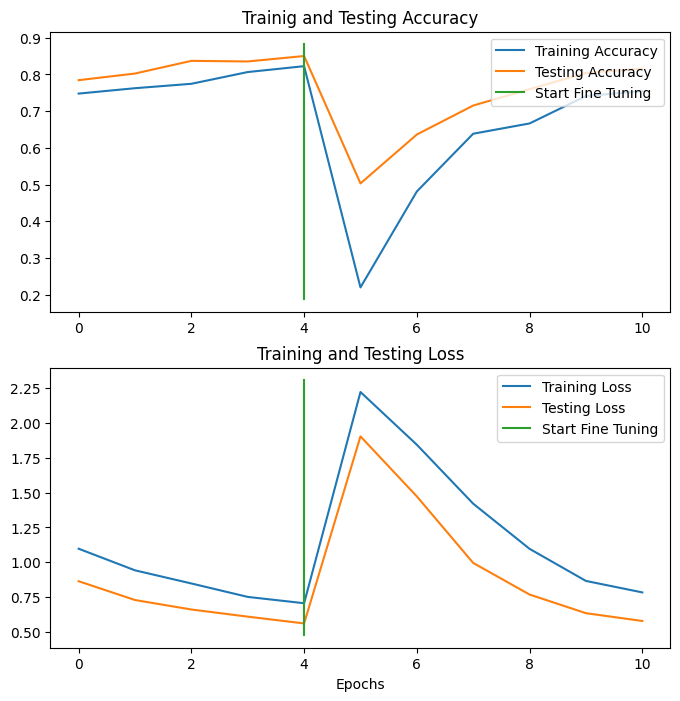

In [71]:
compare_history(model_2_history, model_3_history, 5)

## Model 4: Fine-tuning an existing model all of the data
Enough talk about how fine-tuning a model usually works with more data, let's try it out.

We'll start by downloading the full version of our 10 food classes dataset.

In [72]:
import zipfile
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip

zip_ref_all_data = zipfile.ZipFile("10_food_classes_all_data.zip")
zip_ref_all_data.extractall()
zip_ref_all_data.close()

--2023-11-05 10:01:20--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 172.253.117.207, 142.250.99.207, 142.250.107.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.253.117.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 519183241 (495M) [application/zip]
Saving to: ‘10_food_classes_all_data.zip’

10_food_classes_all 100%[===================>] 495.13M  63.8MB/s    in 8.5s    

2023-11-05 10:01:28 (58.3 MB/s) - ‘10_food_classes_all_data.zip’ saved [519183241/519183241]



In [73]:
import os
for dirpath, dirnames, filename in os.walk("10_food_classes_all_data"):
  print(f"There are {len(dirnames)} and {len(filename)} in {dirpath}")

There are 2 and 0 in 10_food_classes_all_data
There are 10 and 0 in 10_food_classes_all_data/train
There are 0 and 750 in 10_food_classes_all_data/train/hamburger
There are 0 and 750 in 10_food_classes_all_data/train/ramen
There are 0 and 750 in 10_food_classes_all_data/train/steak
There are 0 and 750 in 10_food_classes_all_data/train/sushi
There are 0 and 750 in 10_food_classes_all_data/train/fried_rice
There are 0 and 750 in 10_food_classes_all_data/train/chicken_wings
There are 0 and 750 in 10_food_classes_all_data/train/chicken_curry
There are 0 and 750 in 10_food_classes_all_data/train/ice_cream
There are 0 and 750 in 10_food_classes_all_data/train/pizza
There are 0 and 750 in 10_food_classes_all_data/train/grilled_salmon
There are 10 and 0 in 10_food_classes_all_data/test
There are 0 and 250 in 10_food_classes_all_data/test/hamburger
There are 0 and 250 in 10_food_classes_all_data/test/ramen
There are 0 and 250 in 10_food_classes_all_data/test/steak
There are 0 and 250 in 10_food

In [74]:
train_dir = "10_food_classes_all_data/train/"
test_dir = "10_food_classes_all_data/test/"

In [75]:
import tensorflow as tf
train_data_all_data = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                                          label_mode = "categorical",
                                                                          image_size = (224, 224))


test_data_all_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                         label_mode = "categorical",
                                                                         image_size = (224, 224))


Found 7500 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


Oh this is looking good. We've got 10x more images in of the training classes to work with.

The test dataset is the same we've been using for our previous experiments.

As it is now, our model_2 has been fine-tuned on 10 percent of the data, so to begin fine-tuning on all of the data and keep our experiments consistent, we need to revert it back to the weights we checkpointed after 5 epochs of feature-extraction.

To demonstrate this, we'll first evaluate the current model_2.

In [76]:
model_2.evaluate(test_data_10_percent)

79/79 [==============================] - 6s 73ms/step - loss: 0.5774 - accuracy: 0.8400


[0.5773836374282837, 0.8399999737739563]

In [77]:
results_model_3

[0.6177160143852234, 0.7896000146865845]

In [78]:
def create_base_model(input_shape: tuple[int, int, int] = (224, 224, 3),
                      output_shape: int = 10,
                      learning_rate: float = 0.001,
                      training: bool = False) -> tf.keras.Model:


    base_model = tf.keras.applications.efficientnet_v2.EfficientNetV2B0(include_top=False)
    base_model.trainable = training


    inputs = tf.keras.layers.Input(shape=input_shape, name="input_layer")
    x = data_augmentation(inputs)
    x = base_model(x, training=False)
    x = tf.keras.layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)
    outputs = tf.keras.layers.Dense(units=output_shape, activation="softmax", name="output_layer")(x)
    model = tf.keras.Model(inputs, outputs)


    model.compile(loss="categorical_crossentropy",
                  optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                  metrics=["accuracy"])

    return model

To keep our experiments clean, we'll load a create a new instance of model_2 using our create_base_model() function.

More specifically, we're trying to measure:

* Experiment 3 (previous one) - model_2 with 10 layers fine-tuned for 5 more epochs on 10% of the data.
* Experiment 4 (this one) - model_2 with layers fined-tuned for 5 more epochs on 100% on the data.
Importantly, both experiments should use the same test data (to keep evaluation the same).

And they should also start from the same checkpoint (model_2 feature extractor trained for 5 epochs on 10% of the data).

Let's first create new instance of model_2.

In [79]:
model_4 = create_base_model(learning_rate = 0.0001)

In [80]:
model_4.load_weights(checkpoint_path)

In [81]:
model_4.summary()

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequent  (None, None, None, 3)     0         
 ial)                                                            
                                                                 
 efficientnetv2-b0 (Functio  (None, None, None, 1280   5919312   
 nal)                        )                                   
                                                                 
 global_average_pooling_lay  (None, 1280)              0         
 er (GlobalAveragePooling2D                                      
 )                                                               
                                                                 
 output_layer (Dense)        (None, 10)                1281

In [82]:
print(len(model_4.trainable_variables))

2


In [83]:
model_4.evaluate(test_data_10_percent)

79/79 [==============================] - 8s 62ms/step - loss: 0.5774 - accuracy: 0.8400


[0.5773835778236389, 0.8399999737739563]

Alright, the previous steps might seem quite confusing but all we've done is:

1. Trained a feature extraction transfer learning model for 5 epochs on 10% of the data (with all base model layers frozen) and saved the model's weights using ModelCheckpoint (Model 2).
2. Fine-tuned the same model on the same 10% of the data for a further 5 epochs with the top 10 layers of the base model unfrozen (Model 3).
3. Saved the results and training logs each time.
4. Reloaded the model from 1 to do the same steps as 2 but with all (100%) of the data (Model 4).

The same steps as 2?

Yeah, we're going to fine-tune the last 10 layers of the base model with the full dataset for another 5 epochs but first let's remind ourselves which layers are trainable.

In [84]:
for layer_number, layers in enumerate(model_4.layers):
  print(layer_number, layers.name, layers.trainable)

0 input_layer True
1 data_augmentation True
2 efficientnetv2-b0 False
3 global_average_pooling_layer True
4 output_layer True


Remember, the base_model of model_2 (efficientnetv2-b0) can be referenced by model_2.layers[2].

So let's unfreeze the last 10 layers of the base_model to make them trainable (for fine-tuning).

In [85]:
model_4_base_model = model_4.layers[2]

model_4_base_model.trainable = True

In [86]:
for layer in model_4_base_model.layers[:-10]:
  layers.trainable = False

In [87]:
for layer_number, layers in enumerate(model_4_base_model.layers):
  print(layer_number, layers.name, layers.trainable)

0 input_7 True
1 rescaling_6 True
2 normalization_6 True
3 stem_conv True
4 stem_bn True
5 stem_activation True
6 block1a_project_conv True
7 block1a_project_bn True
8 block1a_project_activation True
9 block2a_expand_conv True
10 block2a_expand_bn True
11 block2a_expand_activation True
12 block2a_project_conv True
13 block2a_project_bn True
14 block2b_expand_conv True
15 block2b_expand_bn True
16 block2b_expand_activation True
17 block2b_project_conv True
18 block2b_project_bn True
19 block2b_drop True
20 block2b_add True
21 block3a_expand_conv True
22 block3a_expand_bn True
23 block3a_expand_activation True
24 block3a_project_conv True
25 block3a_project_bn True
26 block3b_expand_conv True
27 block3b_expand_bn True
28 block3b_expand_activation True
29 block3b_project_conv True
30 block3b_project_bn True
31 block3b_drop True
32 block3b_add True
33 block4a_expand_conv True
34 block4a_expand_bn True
35 block4a_expand_activation True
36 block4a_dwconv2 True
37 block4a_bn True
38 block4a_a

In [88]:
model_4.compile(loss = "categorical_crossentropy",
                optimizer = tf.keras.optimizers.Adam(),
                metrics = ["accuracy"])

In [89]:
model_4_history = model_4.fit(train_data_all_data,
            epochs = fine_tune_epochs,
            initial_epoch = model_2_history.epoch[-1],
            validation_data = test_data_all_data,
            validation_steps = int(0.25 * len(test_data_all_data)),
            callbacks = [create_tensorboard_callback("transfer_learning","full_classes_fine_tuning")])

Saving Tensorboard log file to: transfer_learning/full_classes_fine_tuning/20231105-100223
Epoch 5/10
235/235 [==============================] - 347s 1s/step - loss: 2.3190 - accuracy: 0.1035 - val_loss: 2.3026 - val_accuracy: 0.0921
Epoch 6/10
235/235 [==============================] - 217s 919ms/step - loss: 2.3027 - accuracy: 0.1015 - val_loss: 2.3024 - val_accuracy: 0.1086
Epoch 7/10
235/235 [==============================] - 178s 757ms/step - loss: 2.3027 - accuracy: 0.1011 - val_loss: 2.3029 - val_accuracy: 0.1003
Epoch 8/10
235/235 [==============================] - 146s 622ms/step - loss: 1822.6870 - accuracy: 0.0956 - val_loss: 2.3028 - val_accuracy: 0.1036
Epoch 9/10
235/235 [==============================] - 143s 608ms/step - loss: 2.3026 - accuracy: 0.1000 - val_loss: 2.3028 - val_accuracy: 0.0970
Epoch 10/10
235/235 [==============================] - 130s 547ms/step - loss: 2.3026 - accuracy: 0.1000 - val_loss: 2.3027 - val_accuracy: 0.1003


In [90]:
results_model_4 = model_4.evaluate(test_data_all_data)

results_model_4

79/79 [==============================] - 7s 83ms/step - loss: 2.3026 - accuracy: 0.1000


[2.3026375770568848, 0.10000000149011612]

In [91]:
results_model_3

[0.6177160143852234, 0.7896000146865845]

6
12
[0.2199999988079071, 0.48133334517478943, 0.6386666893959045, 0.6666666865348816, 0.7413333058357239, 0.7546666860580444, 0.10346666723489761, 0.10146666318178177, 0.10106666386127472, 0.09560000151395798, 0.10000000149011612, 0.10000000149011612]


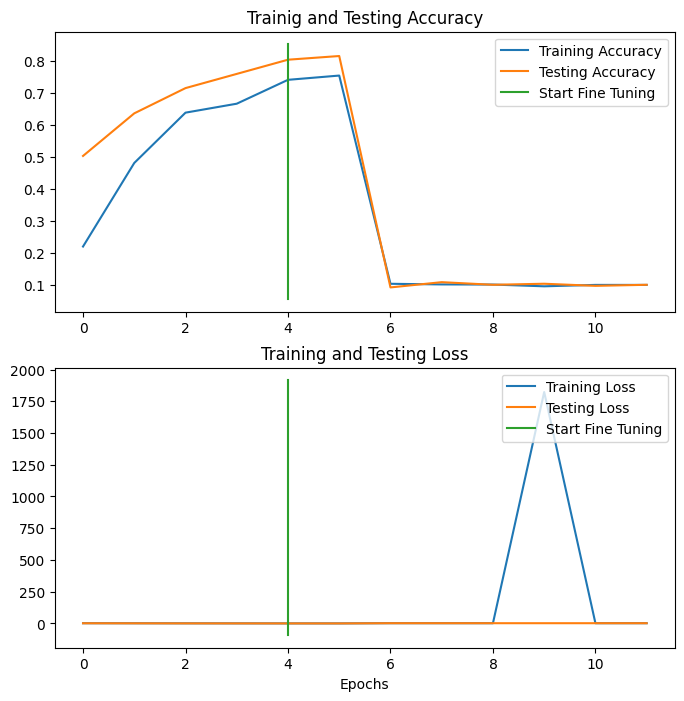

In [97]:
compare_history(original_history=model_3_history,
                 new_history=model_4_history,
                 initial_epoch = 5)

## Model 5

Fine-tune the last 20 layers of the base model you trained in 2 for another 10 epochs

In [99]:
model_5 = create_base_model()


In [100]:
model_5_base_model = model_5.layers[2]

model_5_base_model.trainable = True


for layer in model_5_base_model.layers[:-20]:
  layer.trainable = False

In [101]:
for layer_number, layer in enumerate(model_5_base_model.layers):
  print(layer_number, layer.name, layer.trainable)

0 input_8 False
1 rescaling_7 False
2 normalization_7 False
3 stem_conv False
4 stem_bn False
5 stem_activation False
6 block1a_project_conv False
7 block1a_project_bn False
8 block1a_project_activation False
9 block2a_expand_conv False
10 block2a_expand_bn False
11 block2a_expand_activation False
12 block2a_project_conv False
13 block2a_project_bn False
14 block2b_expand_conv False
15 block2b_expand_bn False
16 block2b_expand_activation False
17 block2b_project_conv False
18 block2b_project_bn False
19 block2b_drop False
20 block2b_add False
21 block3a_expand_conv False
22 block3a_expand_bn False
23 block3a_expand_activation False
24 block3a_project_conv False
25 block3a_project_bn False
26 block3b_expand_conv False
27 block3b_expand_bn False
28 block3b_expand_activation False
29 block3b_project_conv False
30 block3b_project_bn False
31 block3b_drop False
32 block3b_add False
33 block4a_expand_conv False
34 block4a_expand_bn False
35 block4a_expand_activation False
36 block4a_dwconv2 

In [102]:
model_5.compile(loss = "categorical_crossentropy",
                optimizer = tf.keras.optimizers.Adam(),
                metrics = ["accuracy"])

model_5_history = model_5.fit(train_data_all_data,
                epochs = fine_tune_epochs,
                initial_epoch = model_2_history.epoch[-1],
                validation_data = test_data_all_data,
                validation_steps = int(0.25 * len(test_data_all_data)),
                callbacks = [create_tensorboard_callback("transfer learning", "20 layer fine tuning"),
                             checkpoint_callback])

Saving Tensorboard log file to: transfer learning/20 layer fine tuning/20231105-102707
Epoch 5/10
235/235 [==============================] - ETA: 0s - loss: 0.7137 - accuracy: 0.7645
Epoch 5: val_loss improved from 0.56183 to 0.27209, saving model to ten_percent_model_checkpoints_weights/checkpoint.ckpt
235/235 [==============================] - 61s 201ms/step - loss: 0.7137 - accuracy: 0.7645 - val_loss: 0.2721 - val_accuracy: 0.8931
Epoch 6/10
235/235 [==============================] - ETA: 0s - loss: 0.4751 - accuracy: 0.8468
Epoch 6: val_loss improved from 0.27209 to 0.24824, saving model to ten_percent_model_checkpoints_weights/checkpoint.ckpt
235/235 [==============================] - 47s 194ms/step - loss: 0.4751 - accuracy: 0.8468 - val_loss: 0.2482 - val_accuracy: 0.9178
Epoch 7/10
235/235 [==============================] - ETA: 0s - loss: 0.3868 - accuracy: 0.8745
Epoch 7: val_loss did not improve from 0.24824
235/235 [==============================] - 42s 175ms/step - loss: 

In [122]:
model_5.summary()

Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequent  (None, None, None, 3)     0         
 ial)                                                            
                                                                 
 efficientnetv2-b0 (Functio  (None, None, None, 1280   5919312   
 nal)                        )                                   
                                                                 
 global_average_pooling_lay  (None, 1280)              0         
 er (GlobalAveragePooling2D                                      
 )                                                               
                                                                 
 output_layer (Dense)        (None, 10)                1281

In [103]:
class_names = train_data_all_data.class_names

class_names

['chicken_curry',
 'chicken_wings',
 'fried_rice',
 'grilled_salmon',
 'hamburger',
 'ice_cream',
 'pizza',
 'ramen',
 'steak',
 'sushi']

Let's create a function that visualize our predictions.

In [182]:
def visualize_preds(model, dirpath, class_names):
  class_name = random.choice(class_names)
  filename = random.choice(os.listdir(dirpath + "/" + class_name))
  filepath = dirpath + class_name + "/" + filename

  img = tf.io.read_file(filepath)
  img = tf.io.decode_image(img, channels = 3)
  img = img/255
  img = tf.image.resize(img, size = [224,224])

  pred = model.predict(tf.expand_dims(img, axis = 0))

  if len(pred[0]) > 1 :
    pred_class = class_names[pred.argmax()]
  else:
    pred_class = class_names[int(tf.round(pred[0][0]))]

  plt.imshow(img)
  plt.title(f"Prediction: {pred_class}")
  plt.axis("off")
  plt.show()

1/1 [==============================] - 0s 28ms/step


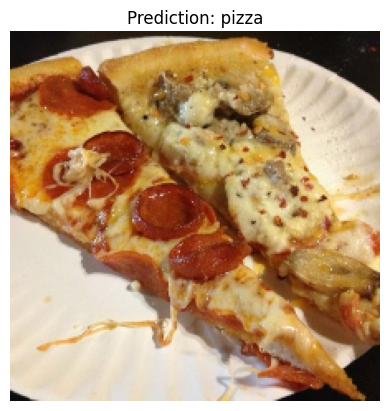

In [187]:
import random
import os
visualize_preds(model_5, train_dir, class_names = class_names)

## Viewing our experiment data on TensorBoard

Right now our experimental results are scattered all throughout our notebook. If we want to share them with someone, they'd be getting a bunch of different graphs and metrics... not a fun time.

But guess what?

Thanks to the TensorBoard callback we made with our helper function create_tensorflow_callback(), we've been tracking our modelling experiments the whole time.

How about we upload them to TensorBoard.dev and check them out?

We can do with the tensorboard dev upload command and passing it the directory where our experiments have been logged.

>🔑 Note: Remember, whatever you upload to TensorBoard.dev becomes public. If there are training logs you don't want to share, don't upload them.

In [ ]:
# View tensorboard logs of transfer learning modelling experiments (should be 4 models)
# Upload TensorBoard dev records
# !tensorboard dev upload --logdir ./transfer_learning \
#   --name "Transfer learning experiments" \
#   --description "A series of different transfer learning experiments with varying amounts of data and fine-tuning" \
#   --one_shot # exits the uploader when upload has finished

In [ ]:
# View previous experiments
# !tensorboard dev list

In [ ]:

# Remove previous experiments
# !tensorboard dev delete --experiment_id OUbW0O3pRqqQgAphVBxi8Q